# Problem 8.2

**Integrated Energy Grids**

**Problem 8.2. Join capacity and dispatch optimization with storage.**

**Use the model described in Problem 8.1 and add the possibility of installing battery storage. The annualized capital cost of the battery comprises  12,894 EUR/MWh/a for the energy capacity and 24,678 EUR/MW/a for the inverter. The inverter efficiency is 0.96 and the battery is assumed to have a fixed energy-to-power ratio of 2 hours. Assume also an existing Combined Cycled Gas Turbine (CCGT) unit with an electricity generation capacity of 6 GW. The annualized capital cost and marginal generation costs for the CCGT are respectively 104,788 EUR/MW/a and 46.8 EUR/MWh.** 

**a) Calculate the optimal installed capacities and plot the hourly generation and demand during January.**

**b) How does the CCGT power plant recover its cost?**

**c) How does the battery recover its cost?**


:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install `pandas` and `numpy` by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pandas pypsa
```
:::

:::{note}
See also https://model.energy.
:::

In this exercise, we want to build a replica of [model.energy](https://model.energy). This tool calculates the cost of meeting a constant electricity demand from a combination of wind power, solar power and storage for different regions of the world. We deviate from [model.energy](https://model.energy) by including electricity demand profiles rather than a constant electricity demand. 

In [225]:
import matplotlib.pyplot as plt
import pandas as pd
import pypsa

## Prerequisites: handling technology data and costs

We maintain a database (https://github.com/PyPSA/technology-data) which collects assumptions and projections for energy system technologies (such as costs, efficiencies, lifetimes, etc.) for given years, which we can load into a `pandas.DataFrame`. This requires some pre-processing to load (e.g. converting units, setting defaults, re-arranging dimensions):

In [226]:
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])

In [227]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["CCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]
costs.at["CCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

Let's also write a small utility function that calculates the **annuity** to annualise investment costs. The formula is

$$
a(r, n) = \frac{r}{1-(1+r)^{-n}}
$$
where $r$ is the discount rate and $n$ is the lifetime.

In [228]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [229]:
annuity(0.07, 20)

0.09439292574325567

Based on this, we can calculate the marginal generation costs (€/MWh):

In [230]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

and the annualised investment costs (`capital_cost` in PyPSA terms, €/MW/a):

In [231]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)

In [232]:
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

We can now read the capital and marginal cost of onshore wind, solar and OCGT

In [233]:
costs.at["onwind", "capital_cost"] #EUR/MW/a

101644.12332388277

In [234]:
costs.at["solar", "capital_cost"] #EUR/MW/a

51346.82981964593

In [235]:
costs.at["OCGT", "capital_cost"] #EUR/MW/a

47718.67056370105

In [236]:
costs.at["OCGT", "marginal_cost"] #EUR/MWh

64.6839512195122

In [237]:
costs.at["CCGT", "capital_cost"] #EUR/MW/a

104788.02078332388

In [238]:
costs.at["CCGT", "marginal_cost"] #EUR/MWh

46.803120689655174

In [239]:
costs.at["battery inverter", "capital_cost"]

24678.157875535107

In [240]:
costs.at["battery storage", "capital_cost"]

12894.531896456368

In [241]:
costs.at["battery inverter", "efficiency"]

0.96

## Retrieving time series data

In this example, wind data from [https://zenodo.org/record/3253876#.XSiVOEdS8l0](https://zenodo.org/record/3253876#.XSiVOEdS8l0) and solar PV data from [https://zenodo.org/record/2613651#.X0kbhDVS-uV](https://zenodo.org/record/3253876#.XSiVOEdS8l0) is used. The data is downloaded in csv format and saved in the 'data' folder.
The Pandas package is used as a convenient way of managing the datasets.

For convenience, the column including date information is converted into Datetime and set as index

In [242]:
data_solar = pd.read_csv('data/pv_optimal.csv',sep=';')
data_solar.index = pd.DatetimeIndex(data_solar['utc_time'])

data_wind = pd.read_csv('data/onshore_wind_1979-2017.csv',sep=';')
data_wind.index = pd.DatetimeIndex(data_wind['utc_time'])

data_el = pd.read_csv('data/electricity_demand.csv',sep=';')
data_el.index = pd.DatetimeIndex(data_el['utc_time'])

The data format can now be analyzed using the .head() function to show the first lines of the data set

In [243]:
data_solar.head()

,utc_time,AUT,BEL,BGR,BIH,CHE,CYP,CZE,DEU,DNK,...,MLT,NLD,NOR,POL,PRT,ROU,SRB,SVK,SVN,SWE
utc_time,,,,,,,,,,,,,,,,,,,,,
1979-01-01 00:00:00+00:00,1979-01-01T00:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 01:00:00+00:00,1979-01-01T01:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 02:00:00+00:00,1979-01-01T02:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 03:00:00+00:00,1979-01-01T03:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 04:00:00+00:00,1979-01-01T04:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will use timeseries for Portugal in this excercise

In [244]:
country = 'PRT'

### Join capacity and dispatch optimization

For building the model, we start again by initialising an empty network, adding the snapshots, and the electricity bus.

In [245]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

n.add("Bus",
            "electricity")

n.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

We add all the technologies we are going to include as carriers. Defining carriers is not mandatory but will ease plotting and assigning emissions of CO2 in future steps. 

In [246]:
carriers = [
    "onwind",
    "solar",
    "OCGT",
    "CCGT",
    "battery storage",
]

n.add(
    "Carrier",
    carriers,
    color=["dodgerblue", "gold", "indianred","yellow-green", "brown"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)

Index(['onwind', 'solar', 'OCGT', 'CCGT', 'battery storage'], dtype='object')

Next, we add the demand time series to the model.

In [247]:
# add load to the bus
n.add("Load",
      "demand",
      bus="electricity",
      p_set=data_el[country].values)

Index(['demand'], dtype='object')

Let's have a check whether the data was read-in correctly.

<Axes: xlabel='snapshot', ylabel='MW'>

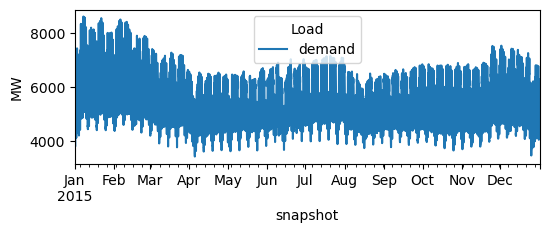

In [248]:
n.loads_t.p_set.plot(figsize=(6, 2), ylabel="MW")

We add now the generators and set up their capacities to be extendable so that they can be optimized together with the dispatch time series. For the wind and solar generator, we need to indicate the capacity factor or maximum power per unit 'p_max_pu'

In [249]:
n.add(
    "Generator",
    "OCGT",
    bus="electricity",
    carrier="OCGT",
    capital_cost=costs.at["OCGT", "capital_cost"],
    marginal_cost=costs.at["OCGT", "marginal_cost"],
    efficiency=costs.at["OCGT", "efficiency"],
    p_nom_extendable=True,
)

CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
n.add(
        "Generator",
        "onwind",
        bus="electricity",
        carrier="onwind",
        p_max_pu=CF_wind.values,
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )

CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
n.add(
        "Generator",
        "solar",
        bus="electricity",
        carrier="solar",
        p_max_pu= CF_solar.values,
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )

Index(['solar'], dtype='object')

So let's make sure the capacity factors are read-in correctly.

<Axes: xlabel='snapshot', ylabel='CF'>

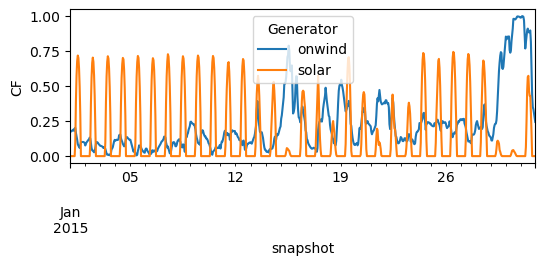

In [250]:
n.generators_t.p_max_pu.loc["2015-01"].plot(figsize=(6, 2), ylabel="CF")

We add the battery storage, assuming a fixed energy-to-power ratio of 2 hours, i.e. if fully charged, the battery can discharge at full capacity for 2 hours. 

For the capital cost, we have to factor in both the capacity and energy cost of the storage. 

We include the charging and discharging efficiencies we enforce a cyclic state-of-charge condition, i.e. the state of charge at the beginning of the optimisation period must equal the final state of charge.

In [251]:
n.add(
    "StorageUnit",
    "battery storage",
    bus="electricity",
    carrier="battery storage",
    max_hours=2,
    capital_cost=costs.at["battery inverter", "capital_cost"]
    + 2 * costs.at["battery storage", "capital_cost"],
    efficiency_store=costs.at["battery inverter", "efficiency"],
    efficiency_dispatch=costs.at["battery inverter", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

Index(['battery storage'], dtype='object')

We add the Combined Cycle Gas Turbine (CCGT). In this case, its capacity is not extendable but fixed to 1 GW. 

In [252]:
n.add(
    "Generator",
    "CCGT",
    bus="electricity",
    carrier="CCGT",
    capital_cost=costs.at["CCGT", "capital_cost"],
    marginal_cost=costs.at["CCGT", "marginal_cost"],
    efficiency=costs.at["CCGT", "efficiency"],
    p_nom=6000, #6 Gw
)

Index(['CCGT'], dtype='object')

### Model Run

We can already solved the model using the open-solver "highs" or the commercial solver "gurobi" with the academic license

In [253]:
n.optimize(solver_name="highs")

Index(['electricity'], dtype='object', name='Bus')
Index(['electricity'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 30.36it/s]
INFO:linopy.io: Writing time: 1.27s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61324 primals, 140164 duals
Objective: 2.26e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

Now, we can look at the results and evaluate the total system cost (in billion Euros per year)

In [254]:
n.objective / 1e9

2.2611491251719444

The optimised capacities in GW:

In [255]:
n.generators.p_nom_opt.div(1e3)  # MW -> GW

Generator
OCGT      2.252259
onwind   -0.000000
solar     9.761450
CCGT      6.000000
Name: p_nom_opt, dtype: float64

The optimised battery capacity can be calcualted as 

In [258]:
n.storage_units.p_nom_opt.div(1e3)  # MW -> GW

StorageUnit
battery storage    0.365741
Name: p_nom_opt, dtype: float64

The total energy generation by technology in TWh:

In [259]:
n.generators_t.p.sum().div(1e6)  # MWh -> TWh

Generator
OCGT       0.714574
onwind     0.000000
solar     14.312445
CCGT      33.921320
dtype: float64

We can plot the dispatch of every generator thoughout January

<Axes: xlabel='snapshot', ylabel='dispatch'>

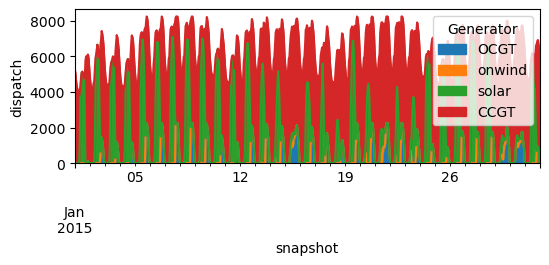

In [260]:
n.generators_t.p.loc["2015-01"].plot.area(figsize=(6, 2), ylabel="dispatch")

We can also plot the charging and discharging of the battery

<Axes: xlabel='snapshot', ylabel='battery'>

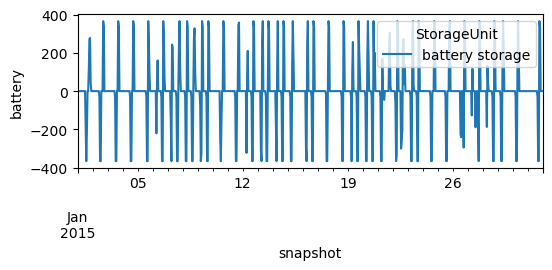

In [261]:
n.storage_units_t.p.loc["2015-01"].plot(figsize=(6, 2), ylabel="battery")

and the demand time series

<Axes: xlabel='snapshot', ylabel='demand'>

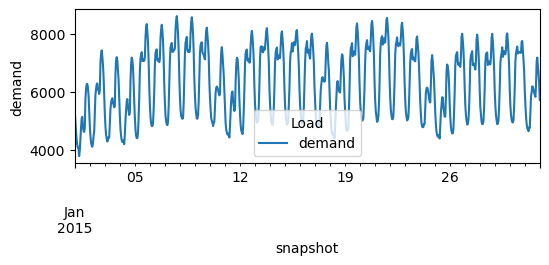

In [263]:
n.loads_t.p.loc["2015-01"].plot(figsize=(6, 2), ylabel="demand")

**b) How does the CCGT power plant recover its cost?**

To calculate the revenues collected by every technology, for every generator, we multiply the energy generated in very hour by the electricity price in that hour and sum for the entire year.

In [264]:
n.generators_t.p.multiply(n.buses_t.marginal_price.to_numpy()).sum().div(1e6) # EUR -> MEUR

Generator
OCGT       153.696309
onwind       0.000000
solar      501.371243
CCGT      1988.635424
dtype: float64

This corresponds to the total cost for every technology, which we can also read using the statistics module:

In [265]:
(n.statistics.capex() + n.statistics.opex()).div(1e6)

component    carrier        
Generator    CCGT               2216.351778
             OCGT                153.696309
             solar               501.371243
StorageUnit  battery storage            NaN
dtype: float64

The CCGT does not recover its full cost. This is to be expected because its capacity was not optimized but set exogenously 

**c) How does the battery recover its cost?**

The battery capacity is also co-optimized with the dispatch, so it exactly recovers its cost by buying electricity when the price is low and selling when it is high. The revenues from market can be calculated by multiplying the battery charging and discharging by the electricity price time series

In [266]:
n.storage_units_t.p.multiply(n.buses_t.marginal_price.to_numpy()).sum().div(1e6) # EUR -> MEUR

StorageUnit
battery storage    18.457919
dtype: float64

The market revenues exactly correspons with the total battery costs

In [267]:
n.storage_units.p_nom_opt*(costs.at["battery inverter", "capital_cost"]+ 2 * costs.at["battery storage", "capital_cost"])/(1e6)# EUR -> MEUR

StorageUnit
battery storage    18.457919
Name: p_nom_opt, dtype: float64

We can calculate the total emissions from the unconstrained model by adding the dispatch of every technology and its emissions

In [268]:
emissions = (
    n.generators_t.p
    / n.generators.efficiency
    * n.generators.carrier.map(n.carriers.co2_emissions)
)  # t/h

In [269]:
emissions.sum().div(1e6)  # tCO2 -> MtCO2

Generator
OCGT       0.345087
onwind     0.000000
solar      0.000000
CCGT      11.580037
dtype: float64